In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import IPython
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py

In [8]:
# cuda device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Generate the one hot encoded supervised dataset
ds_variation = 'negative'
output_dir = 'mnist_neg'

# make the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the one-hot encoding function
def one_hot_encode(label, num_classes=10, random=False):
    one_hot = np.zeros(num_classes)
    if not random:
        one_hot[label] = 1
    else:
        one_hot[np.random.randint(0, num_classes)] = 1
    return one_hot

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# Create new datasets and copy over the data and targets
train_neg_dataset = []
test_neg_dataset = []

for dataset, neg_dataset in [(train_dataset, train_neg_dataset), (test_dataset, test_neg_dataset)]:
    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]
        if ds_variation == 'positive':
            one_hot = one_hot_encode(label, random=False)
        elif ds_variation == 'negative':
            one_hot = one_hot_encode(label, random=True)
        # Replace the first 10 values in the image with the one-hot encoding
        neg_image = torch.cat((torch.tensor(one_hot), image.view(-1)[10:]))
        neg_dataset.append((neg_image, label))

train_aug_images, train_aug_labels = zip(*train_neg_dataset)
test_aug_images, test_aug_labels = zip(*test_neg_dataset)

train_neg_dataset = torch.utils.data.TensorDataset(torch.stack(train_aug_images), torch.tensor(train_aug_labels))
test_neg_dataset = torch.utils.data.TensorDataset(torch.stack(test_aug_images), torch.tensor(test_aug_labels))

# Save the datasets in hdf5 format
dataset_dir = Path(output_dir)
train_file = os.path.join(dataset_dir, 'train.hdf5')
test_file = os.path.join(dataset_dir, 'test.hdf5')

with h5py.File(train_file, 'w') as f:
    f.create_dataset('input', data=train_neg_dataset.tensors[0].numpy())
    f.create_dataset('target', data=train_neg_dataset.tensors[1].numpy())

with h5py.File(test_file, 'w') as f:
    f.create_dataset('input', data=test_neg_dataset.tensors[0].numpy())
    f.create_dataset('target', data=test_neg_dataset.tensors[1].numpy())

 20%|██        | 12171/60000 [00:01<00:05, 8040.65it/s]


KeyboardInterrupt: 

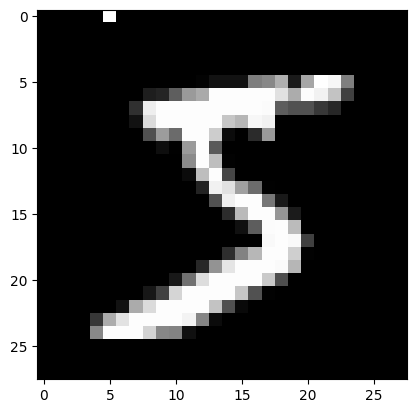

In [ ]:
# Plot the first image of the train_aug_dataset with small figure size
plt.imshow(train_neg_dataset[0][0].view(28, 28), cmap='gray')

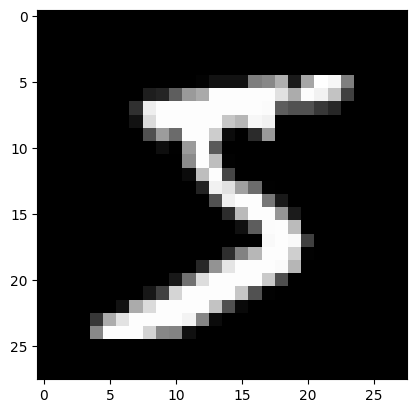

In [ ]:
# Plot the first image of the train_dataset
plt.imshow(train_dataset[0][0].view(28, 28), cmap='gray')

In [30]:
# Load a HDF5 dataset
import h5py

def load_hdf5_dataset(file_path):
    with h5py.File(file_path, 'r') as f:
        input = f['input'][:]
        target = f['target'][:]
    return input, target

# Load the datasets
train_input, train_target = load_hdf5_dataset('mnist_pos/train.hdf5')
train_neg_input, train_neg_target = load_hdf5_dataset('mnist_neg/train.hdf5')
# Load test sets
test_input, test_target = load_hdf5_dataset('mnist_pos/test.hdf5')

# Move to cuda
train_input = torch.tensor(train_input).to(device)
train_target = torch.tensor(train_target).to(device)
train_neg_input = torch.tensor(train_neg_input).to(device)
train_neg_target = torch.tensor(train_neg_target).to(device)
test_input = torch.tensor(test_input).to(device)
test_target = torch.tensor(test_target).to(device)

type(test_input)

torch.Tensor

In [57]:
# Build the forward forward net

# Hyperparameters
torch.manual_seed(42)
lr = 4e-5

# class CNNBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
#         super().__init__()
#         self.cnn = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         out = self.relu(self.cnn(x))
#         return out

class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.relu = nn.ReLU()
        self.layernorm = nn.LayerNorm(out_features)
        
    def forward(self, x, is_pos, training=True):
        out = self.relu(self.linear(x))
        # sum the squared activations of out
        goodness = torch.sum(out**2) 
        
        if training:
            # Update weights based on goodness value.
            self.linear.weight.grad = None
            # Manual gradient calculation
            d_goodness_d_out = 2 * out
            d_out_d_W = x.T
            d_goodness_d_W = d_goodness_d_out * d_out_d_W
            self.linear.weight.grad = d_goodness_d_W.T

            # apply sigmoid to goodness
            pos_prob = torch.sigmoid(goodness)            
            
            with torch.no_grad():
                if is_pos:
                    # print('pos', goodness)
                    self.linear.weight += self.linear.weight.grad * lr
                else:
                    # print('neg', goodness)
                    self.linear.weight -= self.linear.weight.grad * lr

        # Layer Norm
        out = self.layernorm(out)

        return out, goodness.item()

class ForwardForwardNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = LinearBlock(in_features=784, out_features=2000)
        self.hidden2 = LinearBlock(in_features=2000, out_features=2000)
        self.hidden3 = LinearBlock(in_features=2000, out_features=2000)
        self.hidden4 = LinearBlock(in_features=2000, out_features=2000)
        # self.hidden1 = CNNBlock(in_channels=1, out_channels=128, kernel_size=4, stride=6, padding=1), # (B, 128, 5, 5)
        # self.hidden2 = CNNBlock(in_channels=128, out_channels=220, kernel_size=3), # (B, 220, 3, 3)
        # self.hidden3 =CNNBlock(in_channels=220, out_channels=512, kernel_size=2), # (B, 512, 2, 2)
        self.output = nn.Linear(6000, 10)
        self.softmax = nn.Softmax(dim=1)
        self.training = True

    def forward(self, x, is_pos, goodness):
        out1, goodness1 = self.hidden1(x, is_pos, training=self.training)
        out2, goodness2 = self.hidden2(out1, is_pos, training=self.training)
        out3, goodness3 = self.hidden3(out2, is_pos, training=self.training)
        out4, goodness4 = self.hidden4(out3, is_pos, training=self.training)

        # append to goodness
        goodness.append(goodness1)

        # concatenate final 3 layers and put it through a classifier layer
        cat = torch.cat((out2, out3, out4), dim=1)
        logits = self.output(cat)
        probs = self.softmax(logits)

        return probs, goodness

def evaluate_model():
    # Run the model through the test dataset and see how well the model outputs the correct label
    with torch.no_grad():
        num_correct = 0
        num_samples = len(test_input)
        m.training = False
        for x, y in tqdm(zip(test_input, test_target), total=len(test_input)):
            x = x.view(1, -1).float()
            # Make first 10 tensor values 0.1
            x[:, :10] = 0.1
            probs, _ = m(x, is_pos=True, goodness=[])
            _, predictions = probs.max(1)
            num_correct += 1 if predictions.item() == y.item() else 0
        acc = float(num_correct)/float(num_samples)
        print(f'Got {num_correct} / {num_samples} with accuracy {acc*100:.2f} %')
        # sum the value of the first linear layer
        print('Sum of first layer', torch.sum(m.hidden1.linear.weight))
    m.training = True


m = ForwardForwardNet()
m.to(device)

# Train the forward forward net
goodness_pos, goodness_neg = [], []
num_epoch = 1
for i in range(num_epoch):
    # zip positive and negative in a for loop
    for iter, (x_pos, x_neg) in tqdm(enumerate(zip(train_input, train_neg_input)), total=len(train_input)):
        # convert numpy ndarray to tensor
        x_pos = x_pos.view(1, -1).float()
        pos_probs, goodness_pos = m(x_pos, is_pos=True, goodness=goodness_pos)

        # Negative forward pass
        x_neg = x_neg.view(1, -1).float()        
        neg_probs, goodness_neg = m(x_neg, is_pos=False, goodness=goodness_neg)

        # Every X iters, get the average of the last X iters and evaluate
        if iter % 10000 == 0 and iter != 0:
            print('Pos', np.mean(goodness_pos[-1000:]))
            print('Neg', np.mean(goodness_neg[-1000:]))
            print('Ratio', (np.mean(goodness_pos[-1000:]) - np.mean(goodness_neg[-1000:])) / (np.mean(goodness_pos[-1000:]) + np.mean(goodness_neg[-1000:])) * 100, '%')
            evaluate_model()

 17%|█▋        | 9991/60000 [00:24<02:01, 410.36it/s]

Pos 33.74120161533356
Neg 33.11360060691833
Ratio 0.9387523222772112 %


 17%|█▋        | 10074/60000 [00:30<25:21, 32.81it/s]

Got 223 / 10000 with accuracy 2.23 %
Sum of first layer tensor(-69.2201, device='cuda:0')


 33%|███▎      | 19971/60000 [00:54<01:39, 401.20it/s]

Pos 48.99922282314301
Neg 46.99730640125274
Ratio 2.085405001685743 %


 33%|███▎      | 20053/60000 [01:00<20:34, 32.36it/s] 

Got 822 / 10000 with accuracy 8.22 %
Sum of first layer tensor(30.6824, device='cuda:0')


 50%|████▉     | 29986/60000 [01:24<01:13, 408.38it/s]

Pos 70.18164380455018
Neg 65.95442250823974
Ratio 3.1051442948247483 %


 50%|█████     | 30068/60000 [01:30<15:09, 32.90it/s] 

Got 886 / 10000 with accuracy 8.86 %
Sum of first layer tensor(233.9548, device='cuda:0')


 67%|██████▋   | 39981/60000 [01:54<00:48, 410.35it/s]

Pos 124.21997494888306
Neg 115.50639299964905
Ratio 3.6348033067037364 %


 67%|██████▋   | 40064/60000 [02:00<10:10, 32.66it/s] 

Got 93 / 10000 with accuracy 0.93 %
Sum of first layer tensor(499.4842, device='cuda:0')


 83%|████████▎ | 49962/60000 [02:24<00:24, 413.34it/s]

Pos 202.20234745788574
Neg 186.43264463806153
Ratio 4.057715630488295 %


 83%|████████▎ | 50045/60000 [02:30<04:59, 33.24it/s] 

Got 96 / 10000 with accuracy 0.96 %
Sum of first layer tensor(870.2909, device='cuda:0')


 87%|████████▋ | 52408/60000 [02:35<00:22, 335.97it/s]


KeyboardInterrupt: 

In [52]:
# plot two lists side by side
def plot_two_lists(list1, list2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(list1)
    ax[0].set_title('Goodness of Positive')
    ax[1].plot(list2)
    ax[1].set_title('Goodness of Negative')
    plt.show()

plot_two_lists(goodness_pos, goodness_neg)

<Figure size 1000x500 with 2 Axes>
